Press forward button to start the program
Starting the program


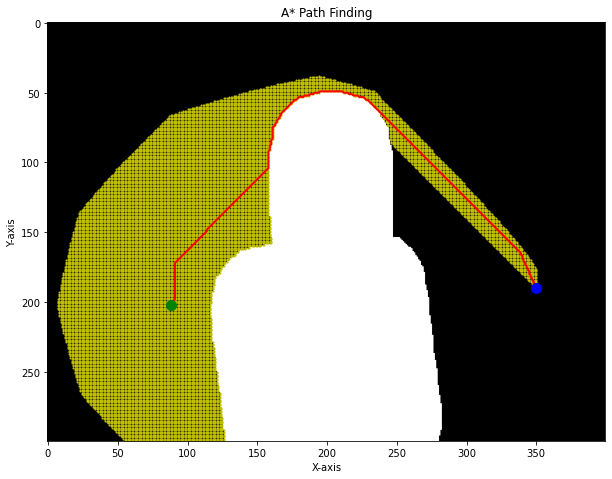

Mission accomplished
mean delta t:0.21273764610290527
Press forward button to start the program
Starting the program


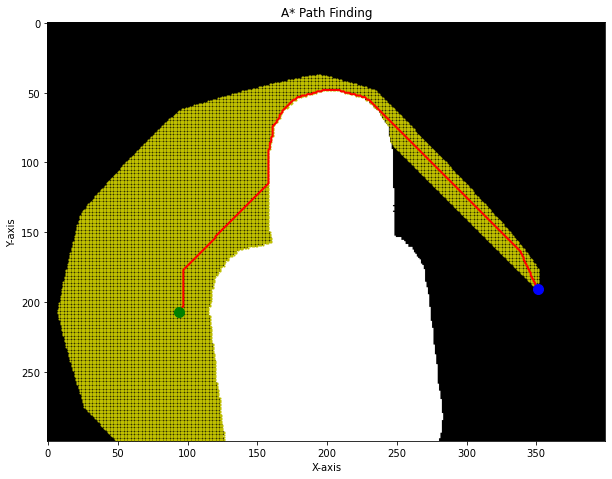

Mission accomplished
mean delta t:0.2195523500442505
Press forward button to start the program
Starting the program


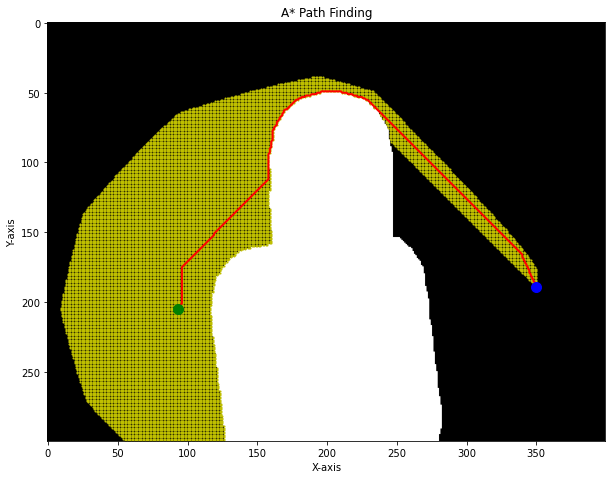

Thymio was kidnapped !
Thymio back on the ground


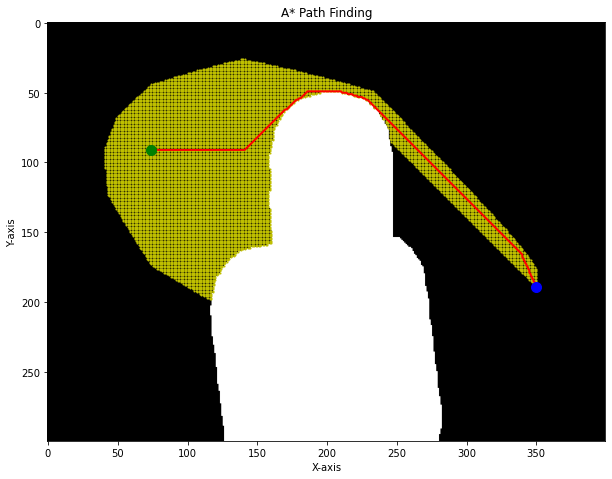

Thymio was kidnapped !
Thymio back on the ground
Couldn't find path, stopping the mission
Press forward button to start the program
Starting the program


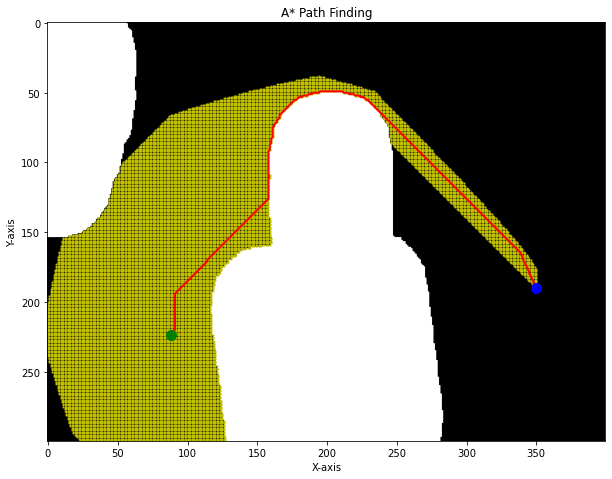

stopping
Press forward button to start the program
Starting the program


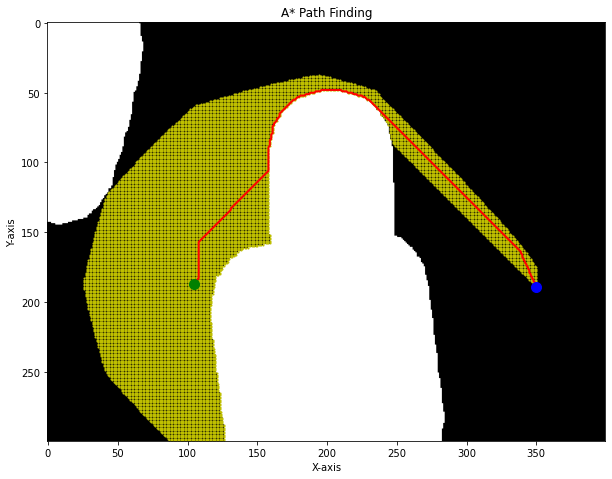

Obstacle
Recalculating path
Obstacle
Recalculating path
Obstacle
Recalculating path
Obstacle
Recalculating path
Obstacle
Recalculating path
Mission accomplished
mean delta t:0.23883289396762847
Press forward button to start the program


In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from camera import *
from thymio import *
from path import *
from motion_control import *
from buttons import*
from drawings import *

###########################################################
# Parameters
###########################################################
CAMERA_INDEX = 1 #0 if no webcam
CORNER_ARUCO_ID = [0, 1, 2, 10] #top-left, bottom-left, bottom-right, top-right
CORNER_ARUCO_SIZE = 65          #[mm]
MIN_SIZE = 500 #minimum blob size
COLOR_OBSTACLE = np.array([[30,30,90,130,100,255]]) #BGR
COLOR_GOAL = np.array([30,40,20,80,140,65])        #BGR
THYMIO_ID = 9
GRID_L = 400  # [pixels]
GRID_W = 300  # [pixels]
DISTANCE_THRESH = 80  # [mm]
deltqthist=[]
###########################################################
# Main Code
###########################################################
from tdmclient import ClientAsync, aw

client = ClientAsync()


async def main():

    node = await client.wait_for_node()
    aw(node.lock())
    
    print("Press forward button to start the program")
    beginning = False
    while(beginning == False) :
        beginning = await wait_for_start_button(node, client)
        time.sleep(0.3)
    cv2.destroyAllWindows()
    print("Starting the program")

    # Camera initialization
    cam = camera_class(
        CAMERA_INDEX,
        CORNER_ARUCO_ID,
        CORNER_ARUCO_SIZE,
        MIN_SIZE,
        COLOR_OBSTACLE,
        COLOR_GOAL,
    )
    while not cam.corners_found:
        cam = camera_class(
        CAMERA_INDEX,
        CORNER_ARUCO_ID,
        CORNER_ARUCO_SIZE,
        MIN_SIZE,
        COLOR_OBSTACLE,
        COLOR_GOAL,
    )


    # Thymio initialization
    Thymio = Thymio_class(THYMIO_ID, cam)

    path_planning = True
    local_avoidance = False
    step = 0
    kidnapped = False
    
    while True :    
        step = step + 1
        
        await node.set_variables(
            {
                "leds.bottom.left" : [0, 0, 0],
                "leds.temperature" : [0, 0]
            }
        )
        
        # Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix = False)
        
        # Thymio Position and motor
        Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()
        deltqthist.append(Thymio.delta_t)
        #print(f"Time for the loop:{Thymio.delta_t}")

        #Kalman Filter
        v_L, v_R = await gather_data(node)
        Thymio.kalman_predict_state(v_L, v_R)  
        if Thymio.Thymio_detected:  #only update if Thymio detected
            Thymio.kalman_update_state()

        #Update history for final plot
        if((step % 3) == 0):
            Thymio.xytheta_meas_hist = np.vstack((Thymio.xytheta_meas_hist, Thymio.xytheta_meas))
            Thymio.xytheta_est_hist = np.vstack((Thymio.xytheta_est_hist, Thymio.xytheta_est))
        
        #Check kidnapping
        if(await check_kidnapping(node)):
            draw_on_image(cam, Thymio, path_img)
            if(kidnapped == False):
                print("Thymio was kidnapped !")
            kidnapped = True
            await set_motors(node, 0, 0)
            continue
        if(kidnapped):
            draw_on_image(cam, Thymio, path_img)
            kidnapped = False
            path_planning = True
            do_plot = True
            #time.sleep(2)
            print("Thymio back on the ground")
            continue
            
        #Path Planning
        if path_planning:
            if Thymio.target_keypoint is None or not np.any(Thymio.target_keypoint):
                do_plot = True
            # if Thymio.target_keypoint==None: #only possible at first iteration to not take time later
            #     do_plot=True
            grid = discretize_image_eff(cam.thresholded_image, GRID_L, GRID_W)
            # Careful! Image frame's first coord (x) is pointing right but in a matrix the first coordinate (rows) is pointing down so they must be inverted
            found, path, _, _ = a_star_search(
                grid,
                grid1_coord2grid2_coord(
                    np.array([Thymio.xytheta_est[1], Thymio.xytheta_est[0]]),
                    cam.persp_image,
                    grid,
                ),
                grid1_coord2grid2_coord(
                    np.array([cam.goal_center[1], cam.goal_center[0]]),
                    cam.persp_image,
                    grid,
                ),
                do_plot,
            )

            if not found:
                print("Couldn't find path, stopping the mission")
                draw_on_image(cam, Thymio, None)
                cv2.waitKey(10)
                aw(node.stop())
                aw(node.unlock())
                break

            # Convert path coordinates for plotting
            path_img = grid1_coord2grid2_coord(path, grid, cam.persp_image)
            path_img = path_img[::-1]

            keypoints = find_keypoints(path_img)
            Thymio.keypoints=keypoints[1:]
            Thymio.target_keypoint = keypoints[0]
            
            do_plot = False
            path_planning = False
        
        #Obstacle detection
        prox_values = await get_prox(node, client)
        if (check_obstacle(prox_values)):
            print("Obstacle")
            local_avoidance = True
            while (check_obstacle(prox_values)):
                prox_values = await get_prox(node, client)
                v_ml, v_mr = avoid_obstacle(prox_values)
                await set_motors(node, v_ml, v_mr)
            await set_motors(node, SPEED*SPEED_SCALING_FACTOR, SPEED*SPEED_SCALING_FACTOR) #move forward to leave the obstacle behind while recalculating path
            #time.sleep(0.2)
            draw_on_image(cam, Thymio, path_img)
            continue
        else:
            if local_avoidance:
                print("Recalculating path")
                path_planning = True
                local_avoidance = False
                draw_on_image(cam, Thymio, path_img)
                continue
        
        #Motion control    
            else:
                if((step % 5) == 0):
                    #print("distance to keypoint: ", distance_to_goal(cam.pixbymm))
                    if((Thymio.distance_to_goal()) < DISTANCE_THRESH):
                        if(len(Thymio.keypoints) <= 1): #Thymio found the goal
                            print("Mission accomplished") 
                            print(f"mean delta t:{np.mean(deltqthist)}")
                            aw(node.stop())
                            aw(node.unlock())
                            draw_history(cam, Thymio, path_img, keypoints)
                            break
                        Thymio.keypoints = Thymio.keypoints[1:]
                        Thymio.target_keypoint = Thymio.keypoints[0]
                    v_ml, v_mr = motion_control(Thymio)
                    await set_motors(node, v_ml, v_mr)
                draw_on_image(cam, Thymio, path_img)

        #Check stop
        if(await check_stop_button(node, client)):
            aw(node.stop())
            aw(node.unlock())
            draw_history(cam, Thymio, path_img, keypoints)
            break
    
    cam.cam.release()
    # cv2.destroyAllWindows()


# Run the main asynchronous function
while True:
    client.run_async_program(main)


In [ ]:
# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
cam.cam.release()

In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
###MARCHE PAS !!!!!!!!!        
        await node.set_variables({
            "leds.top": [0, 0, 0],
            "leds.circle": [0]*8,
            "leds.bottom.left": [0,0,0],
            "leds.bottom.right": [0,0,0],
            "leds.buttons": [0, 0, 0, 0],
            "leds.prox.h": [0]*8,
            "leds.prox.v": [0, 0],
            "leds.sound": [0],
            "leds.temperature": [0, 0]
        })

In [1]:
import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from camera_class import *
from thymio_class import *
from path import *
from motion_control import *
from buttons import*
from drawings import *

###########################################################
# Main Code
###########################################################
from tdmclient import ClientAsync, aw

client = ClientAsync()


async def main():

    node = await client.wait_for_node()
    aw(node.lock())
    await set_motors(node, 500, 500)
    start_time = time.time()
    if(time.time()>=(start_time+5)):
         await set_motors(node, 0, 0)  
         
    
# Run the main asynchronous function
client.run_async_program(main)
